# Present results of VAEM run with 3000 epochs
Only ran the VAEM model for 3000 epochs, training it on the Adult, Asia and Sachs data (not Census)

In [1]:
import numpy as np
print("Numpy version should be 1.19.5:", np.__version__)
import pandas as pd
print("Pandas version should be 0.24.0:", pd.__version__)
import glob
import sklearn
from data_evaluation import univariate_metrics, association_diff, privacy_metrics, dim_wise_pred
import json
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from statistics import mean
from math import sqrt

pd.set_option('display.max_columns', None) # to see all cols when viewing db

C:\Users\jahutter\AppData\Local\Continuum\anaconda2\envs\thesis_venv\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\jahutter\AppData\Local\Continuum\anaconda2\envs\thesis_venv\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\jahutter\AppData\Local\Continuum\anaconda2\envs\thesis_venv\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


Numpy version should be 1.19.5: 1.19.5
Pandas version should be 0.24.0: 1.3.5


In [2]:
datasets = ["Adult", "Asia", "Sachs"]
models = ["vaem"]
exp_suffix=  "_3000epochs"

## Combine univariate metrics

In [4]:
sns.set_theme(style="whitegrid")
df = pd.DataFrame()
for db in datasets:    
    for mod in models:
        res = pd.read_csv("./Univ_stat_tests/univ_stat_tests_"+db+"_"+mod+exp_suffix+".csv")
        for i,row in res.iterrows():
            temp=[]
            stat = row["Statistic"].split("-")[0]
            temp = pd.Series([db, stat, mod.upper(), row["Mean value"]])
            df = df.append(temp, ignore_index=True)
            # add row again but dataset = Mean to get additional bars for mean. Call it zMean to put it at the end
            temp2 = pd.Series(["zMean", stat, mod.upper(), row["Mean value"]]) 
            df = df.append(temp2, ignore_index=True)
cols=["Dataset", "Test", "Model", "Value"]
df.columns=cols

df = df.sort_values(by=["Dataset", "Test", "Model"])
df=df.reset_index(drop=True)
# rename zMean to Mean:
df['Dataset'] = df['Dataset'].replace(['zMean'],'Mean')
df.to_csv("./Univ_stat_tests/combined_table_VAEM3000.csv", index=False)

In [5]:
df.head()

,Dataset,Test,Model,Value
0,Adult,CS,VAEM,1.000000
1,Adult,CS,VAEM,1.000000
2,Adult,CS,VAEM,1.000000
3,Adult,CS,VAEM,0.831559
4,Adult,CS,VAEM,0.999993


<Figure size 432x288 with 0 Axes>

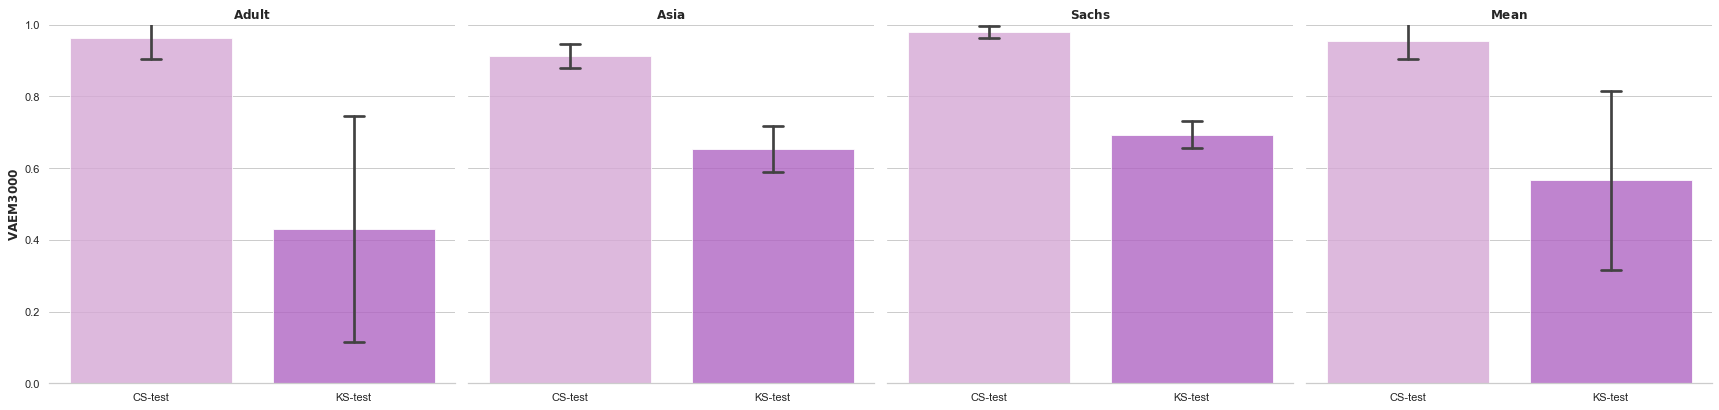

In [11]:
### Make df with columns = [Dataset, Test, Model, Value]:
sns.set_theme(style="whitegrid")
df = pd.DataFrame()
for db in datasets:    
    for mod in models:
        res = pd.read_csv("./Univ_stat_tests/univ_stat_tests_"+db+"_"+mod+exp_suffix+".csv")
        for i,row in res.iterrows():
            temp=[]
            stat = row["Statistic"]#.split("-")[0]
            temp = pd.Series([db, stat, mod.upper(), row["Mean value"]])
            df = df.append(temp, ignore_index=True)
            # add row again but dataset = Mean to get additional bars for mean. Call it zMean to put it at the end
            temp2 = pd.Series(["zMean", stat, mod.upper(), row["Mean value"]]) 
            df = df.append(temp2, ignore_index=True)
cols=["Dataset", "Test", "Model", "Value"]
df.columns=cols

df = df.sort_values(by=["Dataset", "Test", "Model"])
df=df.reset_index(drop=True)
# rename zMean to Mean:
df['Dataset'] = df['Dataset'].replace(['zMean'],'Mean')
df.to_csv("./Univ_stat_tests/combined_table_VAEM3000.csv", index=False)

### Make one plot of CS and one for KS results:
fig = plt.figure()

g = sns.catplot(
    data=df, kind="bar",
    x="Test", y="Value", col="Dataset",  ci="sd", 
    palette=["plum", "mediumorchid"], alpha=0.8, height=6, capsize=0.1,
)
g.despine(left=True)
g.set_axis_labels("", "$\\bf{}$".format("VAEM 3000"))
g.set(ylim=(0, 1))
g.set_titles("$\\bf{col_name}$")
g.figure.savefig("../Evaluation/Univ_stat_tests/barchart_per_db_VAEM"+exp_suffix+".png")

## Combine multivariate metrics
***Association matrix difference***

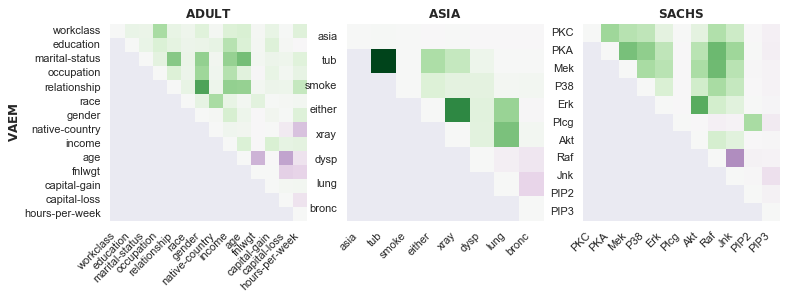

In [16]:
sns.set_theme(style="whitegrid")
sns.set(rc= {"figure.figsize": (4*len(datasets),4*len(models))})
fig, axs = plt.subplots(len(models), len(datasets))

# make multi-index row indexes:
midx=[]
for m in models:
    midx.append((m.upper(), "Max"))
    midx.append((m.upper(), "Pos_RMSE"))
    midx.append((m.upper(), "Neg_RMSE"))
    midx.append((m.upper(), "Min"))
midx = pd.MultiIndex.from_tuples(midx)

df = pd.DataFrame(np.zeros((len(models)*4, len(datasets))), columns = datasets, index = midx)

mod = models[0]
for j in range(len(datasets)):
    diff = pd.read_csv("../Evaluation/Association_matrix/assoc_mtx_"+datasets[j]+"_"+mod+exp_suffix+"_diff.csv", index_col=0)
    # make into upper triangular mtx:
    diff = diff.where(np.triu(np.ones(diff.shape)).astype(np.bool))
    # compute min, max, pos & neg RMSE of diff mtx:
    pos=[]
    neg=[]
    max_v=0
    min_v=0
    for lst in diff.values:
        for v in lst:
            if v>0:
                pos.append(v)
                if v>max_v:
                    max_v=v
            elif v<0:
                neg.append(v)
                if v<min_v:
                    min_v=v
    pos_rmse = round(sqrt(mean([x**2 for x in pos])),3)
    neg_rmse = round(sqrt(mean([x**2 for x in neg])),3)
    df[datasets[j]].loc[mod.upper()]=[max_v.round(3), pos_rmse, neg_rmse, min_v.round(3)]

    g = sns.heatmap(diff, vmin=-1, vmax=1, center=0,cmap="PRGn", square=True, ax = axs[j], cbar=False)
    axs[j].set_xticklabels(axs[j].get_xticklabels(), rotation=45, horizontalalignment='right')
    if j==0: # add model label to first plot:
        g.set_ylabel("$\\bf{}$".format(mod.upper()))
    g.set(title="$\\bf{}$".format(datasets[j].upper()))

df.to_csv("../Evaluation/Association_matrix/assoc_mtx_VAEM"+exp_suffix+"_diff_summmary.csv", index=False)        
fig.figure.savefig("../Evaluation/Association_matrix/assoc_mtx_VAEM"+exp_suffix+"_combined_diff.png")

In [17]:
df

Adult   Asia  Sachs
VAEM Max       0.635  1.000  0.608
     Pos_RMSE  0.203  0.350  0.336
     Neg_RMSE  0.184  0.078  0.107
     Min      -0.403 -0.192 -0.487

***Dimension-wise prediction***

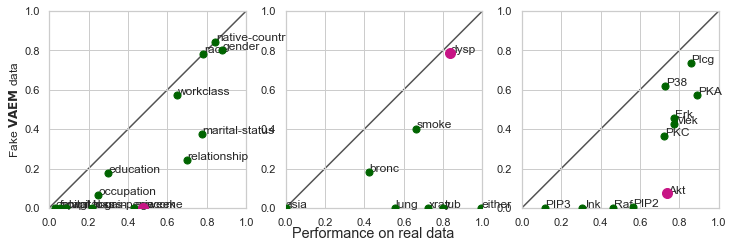

In [19]:
sns.set(rc= {"figure.figsize": (4*len(datasets), 4*len(models))})
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(len(models), len(datasets))
lims = [0,1]


for j in range(len(datasets)):
    df = pd.read_csv("../Evaluation/Dim_wise_pred/dwp_"+datasets[j]+"_"+mod+exp_suffix+".csv")

    dataset_name = datasets[j]
    if dataset_name in ["Adult", "Census"]:
        real_file_root = "../Real_Datasets/"
    else:
        real_file_root = "../BN_Datasets/"
    with open(real_file_root+ dataset_name+"/"+dataset_name+"_meta.json") as json_file:
        meta = json.load(json_file)
    target = meta["target"]

    axs[j].scatter(df["Real_score"], df["Mean_fake_score"], c="darkgreen", s=50, zorder=10)
    # plot original target feature y in violet:
    axs[j].scatter(df[df["Target feature"]==target]["Real_score"], df[df["Target feature"]==target]["Mean_fake_score"], c="mediumvioletred", s=100, zorder=10)
    # plot both limits against eachother to get y=x line
    axs[j].plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    axs[j].set_aspect('equal')
    axs[j].set_xlim(lims)
    axs[j].set_ylim(lims)
    for k, txt in enumerate(list(df["Target feature"])):
        axs[j].annotate(txt, (list(df["Real_score"])[k], list(df["Mean_fake_score"])[k]), xycoords='data', textcoords='offset points')
    if j==0: # add model name to plot in first column
        axs[j].set_ylabel("Fake $\\bf{}$ data".format(models[i].upper()))
fig.suptitle("Performance on real data", y=0.095)
fig.figure.savefig("../Evaluation/Dim_wise_pred/dwp"+exp_suffix+"_combined.png")

## Privacy checks
***DCR***

In [44]:
# Combine F&R pr_ch data from different datasets:  cols=["Dataset", "Model", "DCR", "NNDR"]
fr_df = pd.DataFrame()
for db in datasets:    
    for mod in models:
        res = pd.read_csv("./Privacy_checks/pr_ch_"+db+"_"+mod+exp_suffix+"_raw.csv")
        # drop rows with F&F values:
        res = res.drop(res[res["Type"]=="F&F"].index)
        # drop rows with R&R values:
        res = res.drop(res[res["Type"]=="R&R"].index)
        # only keep R&R results for CTAB model as data is same for all models so only need it once
        #if mod != "ctab": 
        #    res = res.drop(res[res["Type"]=="R&R"].index) 
        temp = pd.DataFrame(data={"Dataset": res["Dataset"], "Model": mod.upper(), "DCR":res["DCR"], "NNDR":res["NNDR"]})
        fr_df = fr_df.append(temp, ignore_index=True)
        # add row again but dataset = Mean to get additional bars for mean - call it zMean to put it at the end
        temp2 = pd.DataFrame(data={"Dataset": "zMean", "Model": mod.upper(), "DCR":res["DCR"], "NNDR":res["NNDR"]})
        fr_df = fr_df.append(temp2, ignore_index=True)

fr_df = fr_df.sort_values(by=["Dataset", "Model"])
fr_df=fr_df.reset_index(drop=True)
# rename zMean to Mean after sorting (so they come last):
fr_df['Dataset'] = fr_df['Dataset'].replace(['zMean'],'Mean')

fr_df.to_csv("./Privacy_checks/combined_type_and_mod_FR"+exp_suffix+".csv", index=False)
fr_df.shape

(107094, 4)

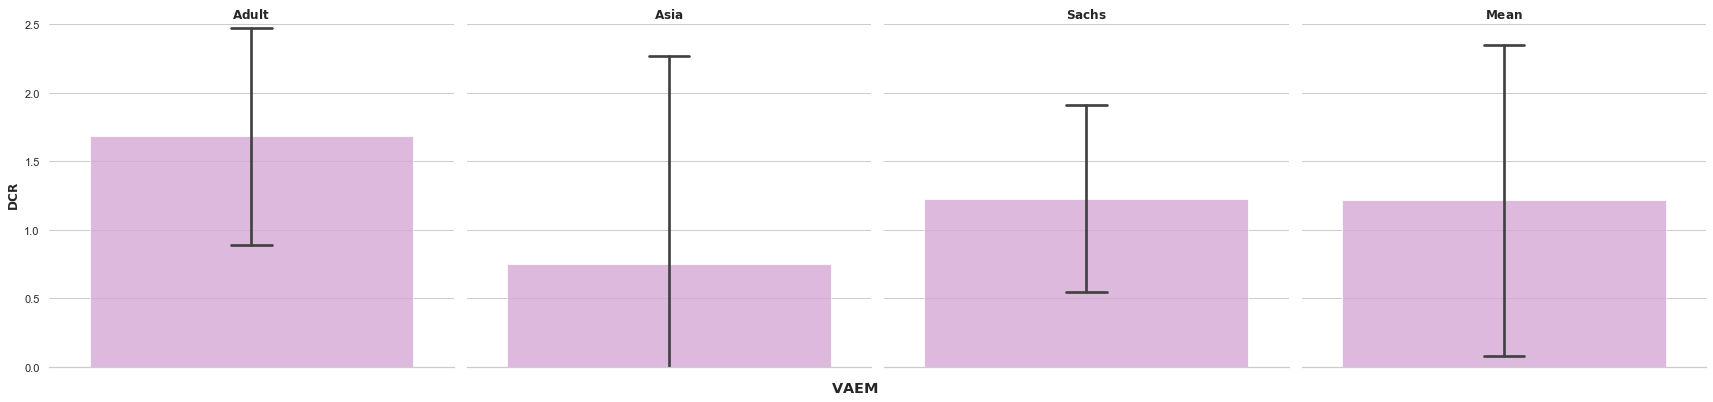

In [46]:
# BARCHART:
g = sns.catplot(
    data=fr_df, kind="bar",
    x="Model", y="DCR", col="Dataset",  ci="sd", 
    palette=["plum"], height=6, alpha=0.8, capsize=0.1,
)
g.despine(left=True)
g.set_axis_labels("", "$\\bf{}$".format("DCR"))
g.set(ylim=(0, 2.5))
g.set_titles("$\\bf{col_name}$")
g.set(xticklabels=[])
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("$\\bf{}$".format("VAEM"), y=0.075)
g.figure.savefig("../Evaluation/Privacy_checks/DCR_FR_barchart"+exp_suffix+".png")

***NNDR***

In [47]:
# Combine F&F and R&R pr_ch data from different datasets:  cols=["Dataset", "Model", "Type (F&F, R&R, F&R)", "DCR", "NNDR"]
df = pd.DataFrame()
for db in datasets:    
    res = pd.read_csv("./Privacy_checks/pr_ch_"+db+"_"+mod+exp_suffix+"_raw.csv")
    temp = pd.DataFrame(data={"Dataset": res["Dataset"], "Model": mod.upper(), "Type": res["Type"], "DCR":res["DCR"], "NNDR":res["NNDR"]})
    df = df.append(temp, ignore_index=True)
    # add row again but dataset = Mean to get additional bars for mean - call it zMean to put it at the end
    temp2 = pd.DataFrame(data={"Dataset": "zMean", "Model": mod.upper(), "Type": res["Type"], "DCR":res["DCR"], "NNDR":res["NNDR"]})
    df = df.append(temp2, ignore_index=True)
df.head()
# Rename cols & sort so have Within Fake, Within Real & then Between data NNDR
df['Type'] = df['Type'].replace(['R&R'],str("Within $\\bf{}$".format("Real")))
df['Type'] = df['Type'].replace(['F&F'],str("Within $\\bf{}$".format("Fake")))
df['Type'] = df['Type'].replace(['F&R'],str("zBetween"))
df = df.sort_values(by=["Dataset", "Model", "Type"])
df['Type'] = df['Type'].replace(['zBetween'],str("$\\bf{}$ data".format("Between")))
df['Dataset'] = df['Dataset'].replace(['zMean'],'Mean')
df=df.reset_index(drop=True)

df.to_csv("./Privacy_checks/combined_type_VAEM"+exp_suffix+".csv", index=False)
df.shape

(249952, 5)

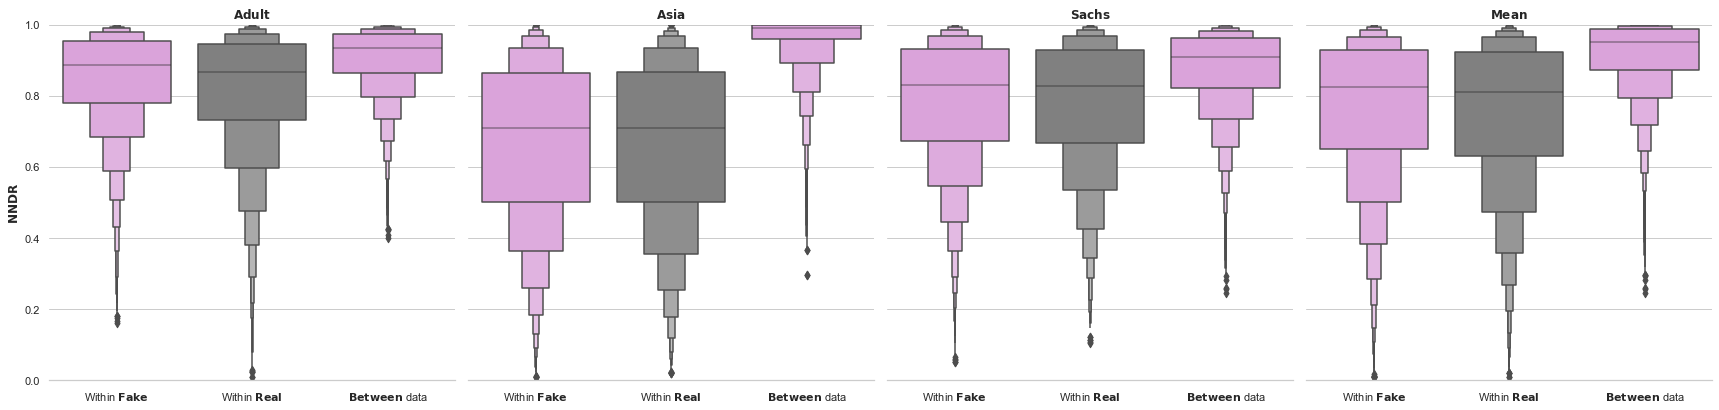

In [48]:
# BOXENPLOT:
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=df, kind="boxen",
    x="Type", y="NNDR", col="Dataset",  ci="sd", 
    palette=["plum", "grey", "plum"], height=6, saturation = 0.9,
)
g.despine(left=True)
g.set_axis_labels("", "$\\bf{}$".format("NNDR"))
g.set(ylim=(0, 1))
g.set_titles("$\\bf{col_name}$")

g.figure.savefig("../Evaluation/Privacy_checks/NNDR_boxplot_VAEM"+exp_suffix+".png")